In [1]:
%matplotlib inline
import scanpy as sc
import scvi
import numpy as np
from sctools import integrate, plot

Global seed set to 0


## Data integration using SCVI
This step aims to harmonize the data and remove batch effects

In [3]:
file_dict = {
    'tissue.scps': 'tissue.scpc.qcfiltered.h5ad',
    'tissue.ad': 'tissue.ad.qcfiltered.h5ad',
    'tissue.uc': 'tissue.uc.qcfiltered.h5ad',
    'pbmc.scps': 'pbmc.scps.qcfiltered.h5ad',
}
adatas = {
    k: sc.read_h5ad(file_name) for k, file_name in file_dict.items()
}

adatas

AnnData object with n_obs × n_vars = 79378 × 18436
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass'

In [5]:
# visualize raw data
for k, adata in adatas.items():
    print(k)
    plot.integrate.raw_data_umap(
        adata,
        ['status', 'tissue', 'FOXP3'],
        size = 10,
        vmax = 0.5
    )

/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepr

In [9]:
integration_params = {
    k: {
        'subset': np.ones(
            shape = adata.obs.shape[0], 
            dtype = bool
        ),
        'kwargs': dict()
    }
    for k in adata.keys()
}

integration_results = {}
for key, adata in adatas.items():
    print(key)
    params = integration_params[key]
    integration_results[key] = integrate.integrate_data_scvi(
        adata[params['subset'], :].copy(),
        'sample_id',
        train_size = 1,
        **params['kwargs']
    )

    integration_results[key]['data'].write(
        f'../data/{key}.integrated.h5ad'
    )

    integration_results[key]['model'].save(
        f'../data/{key}.integration.scvi.model',
        overwrite = True
    )

full
computing highly variable genes


/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/101:   0%|          | 0/101 [00:00<?, ?it/s]

/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 101/101: 100%|██████████| 101/101 [09:40<00:00,  5.75s/it, loss=408, v_num=1]
compute umap from scvi embedding


In [19]:
# restore results if kernel breaks or gets shut down
integration_results = {}
for key in ['tissue.scps', 'tissue.ad', 'tissue.uc', 'pbmc.scps']:
    data = sc.read_h5ad(
        f'../data/{key}.integrated.h5ad'
    )
    integration_results[key] = {
        'data': data,
        'model': scvi.model.SCVI.load(
            f'../data/{key}.integration.scvi.model', 
            adata = data
        )
    }

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


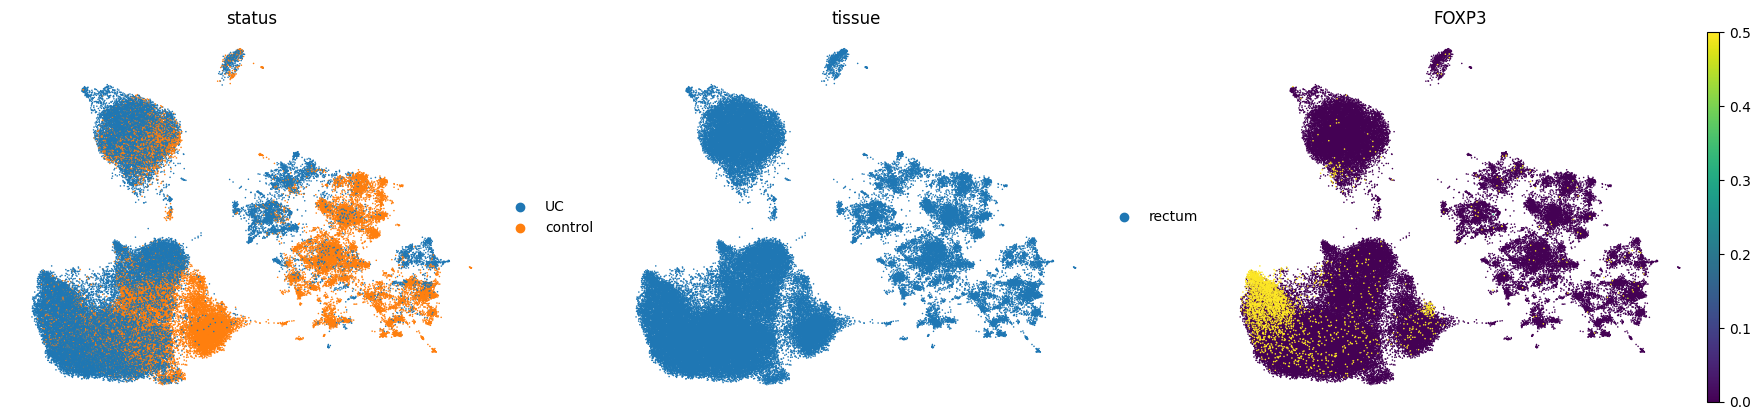

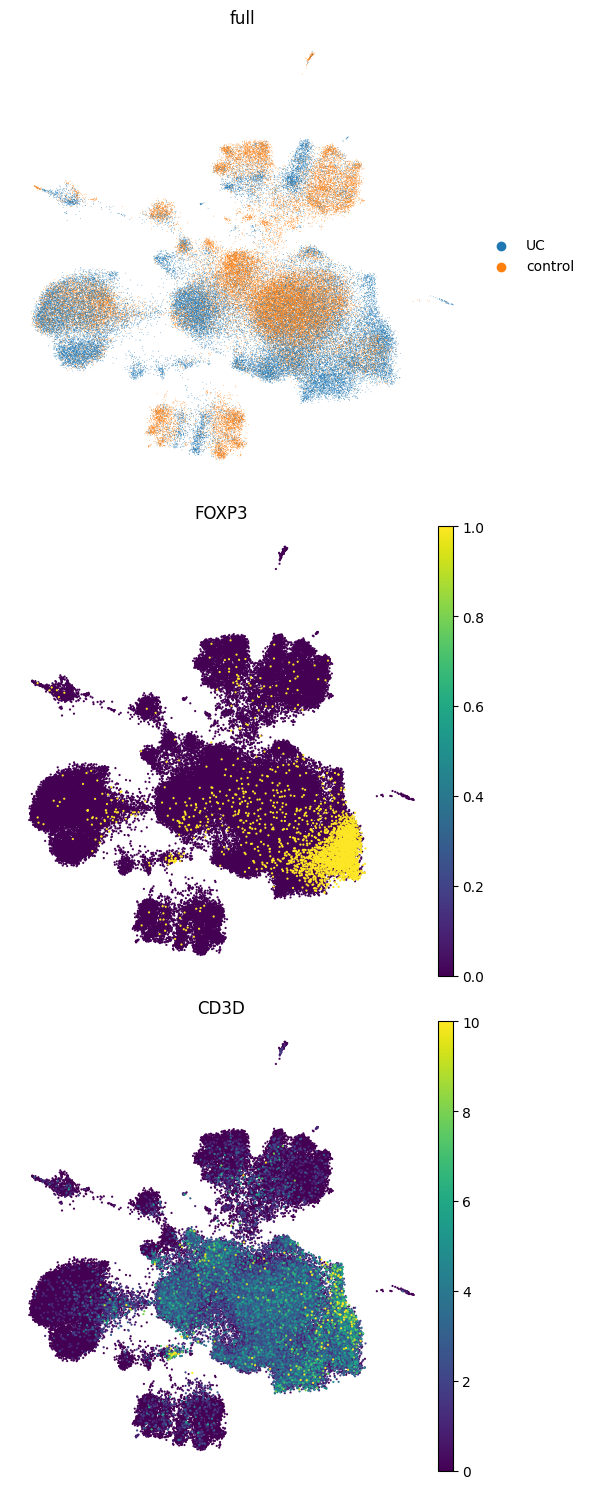

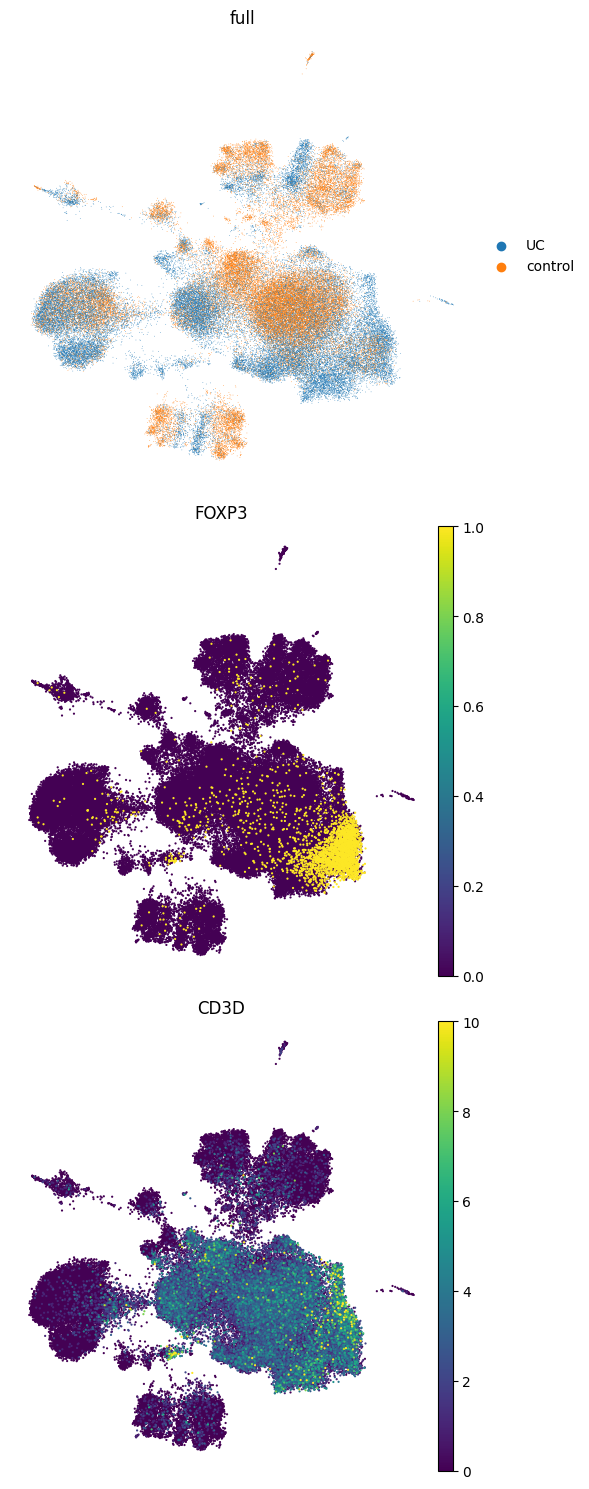

In [14]:
fig, axs = plot.integrate.plot_integration_results(
    integration_results,
    ['status', 'FOXP3', 'CD3D'],
    [
        dict(size = 10, vmax = None),
        dict(size = 10, vmax = 1),
        dict(size = 10, vmax = 10)
    ],
    data_key = 'data'
)

## Identification of T-cell subsets
This section aims at extracting T-cells from full dataset based on CD3D and FOXP3 expression (FOXP3 is taken into account here because the ultimate goal is to extract regulatory T-cells)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

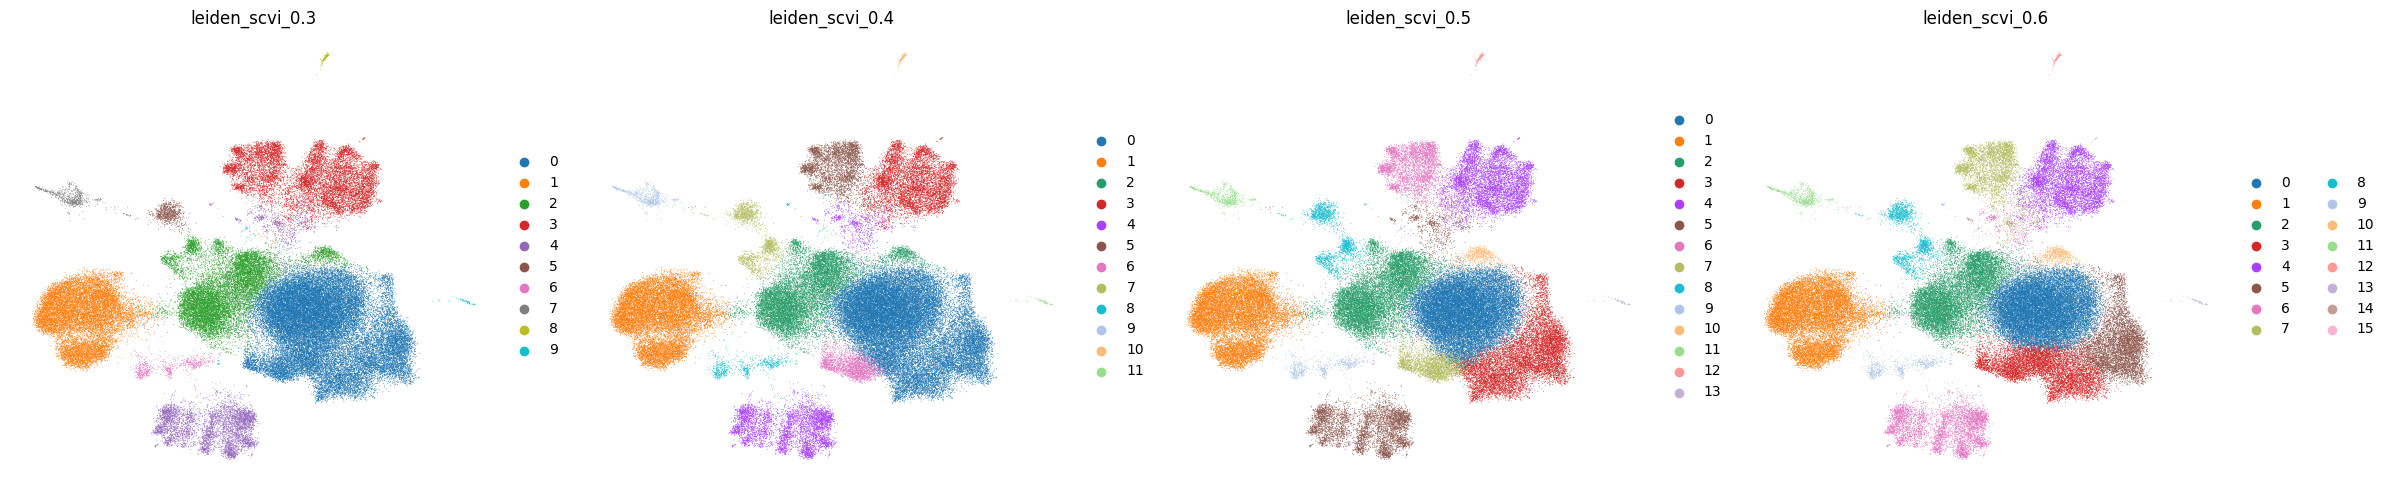

In [16]:
fig, axs = plot.integrate.plot_leiden_clusterings(
    integration_results,
    [0.3, 0.4, 0.5, 0.6],
    data_key = 'data',
    legend_loc = 'right margin'
)

In [17]:
resolutions = {
    'tissue.scps': 0.4,
    'tissue.uc': 0.4,
    'tissue.ad': 0.25,
    'pbmc.scps': 0.5
}
for k, resolution in resolutions.items():
    d = integration_results[k]
    sc.tl.leiden(
        d['data'], 
        key_added = f'leiden_scvi_{resolution}',
        resolution = resolution
    )

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


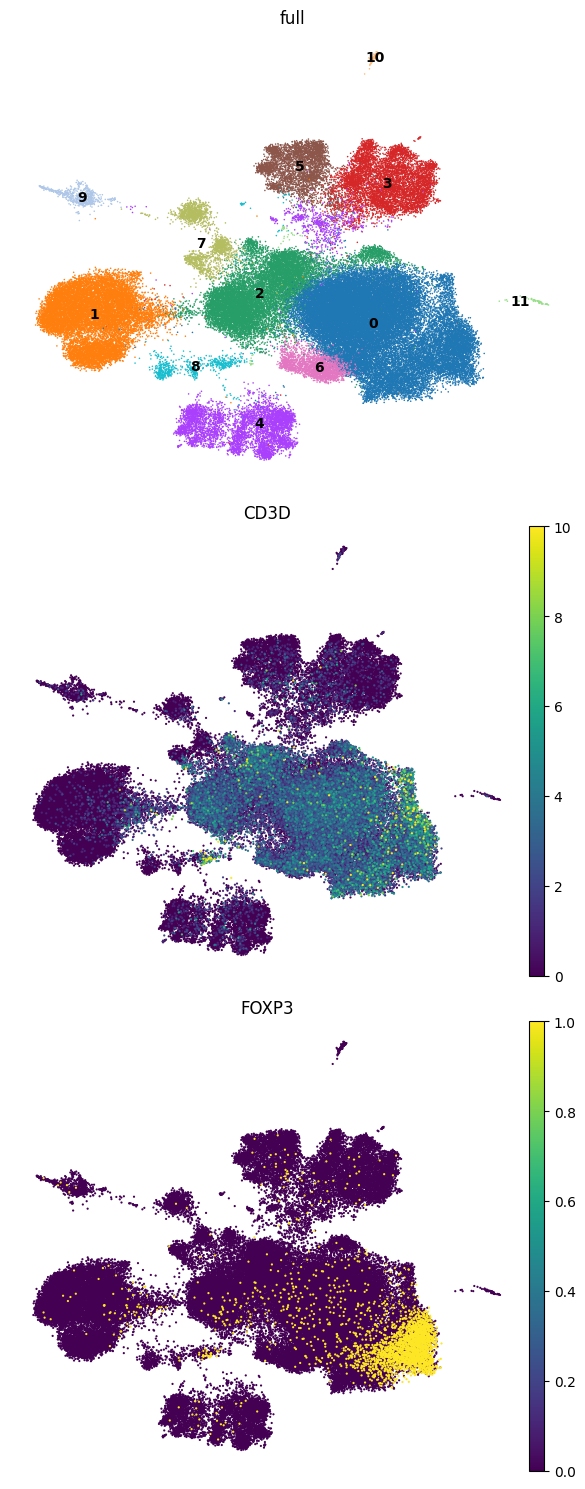

In [18]:
cluster_keys = {k: f'leiden_scvi_{r}' for k, r in resolutions.items()}
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    cluster_keys,
    ['CD3D', 'FOXP3'],
    [
        dict(size = 10, vmax = None, legend_loc = 'on data'),
        dict(size = 10, vmax = 10),
        dict(size = 10, vmax = 1)
    ],
    data_key = 'data'
)

In [ ]:
tcell_clusters = {
    'tissue.scps': '2,4,6',
    'tissue.uc': '2,4,6',
    'tissue.ad': '2,4,6',
    'pbmc.scps': '2,4,6'
}

tcell_clusters = {
    k: [c for c in cs.split(',')] for k, cs in tcell_clusters.items()
}

full coarse_cell_types
Tcell    46867
other    32511
Name: sample_id, dtype: int64


/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


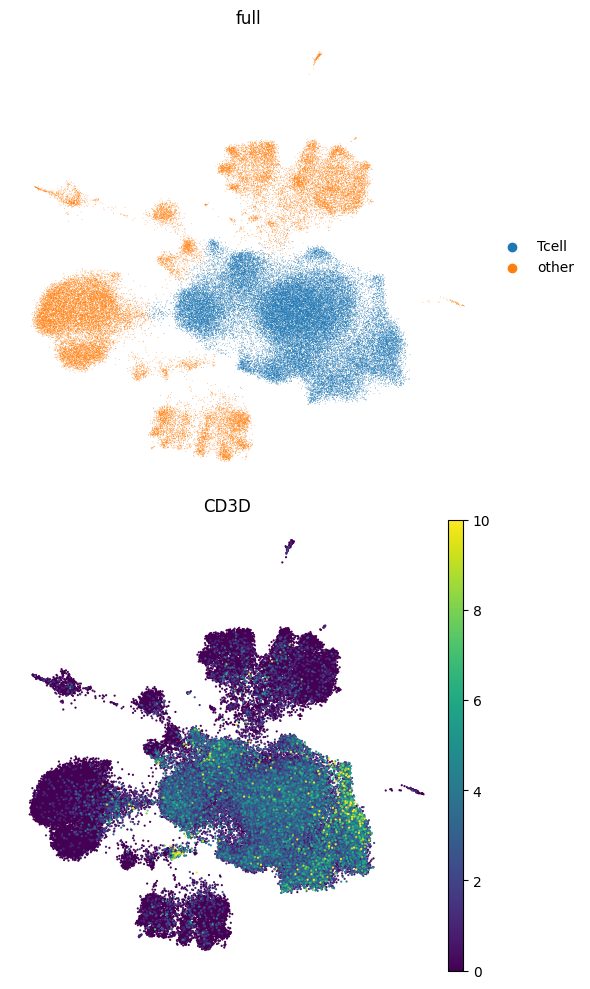

In [ ]:
for k, d in integration_results.items():
    clustering = cluster_keys[k]
    cluster_to_tcell = tcell_clusters[k]
    d['data'].obs['coarse_cell_types'] = d['data'].obs[clustering].apply(
        lambda x: 'Tcell' if x in cluster_to_tcell[k] else 'other'
    )
    print(k, d['data'].obs.groupby('coarse_cell_types').count().iloc[:, 0])
    
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    {k: 'coarse_cell_types' for k in integration_results.keys()},
    ['CD3D'],
    [
        dict(size = 10, vmax = None),
        dict(size = 10, vmax = 10)
    ],
    data_key = 'data'
)

In [ ]:
for k, d in integration_results.items():
    d['data'].write(
        f'../data/{k}.integrated.clustered.h5ad'
    )